In [ ]:
import autogluon
from autogluon.tabular import TabularDataset, TabularPredictor

In [1]:
# ref:
# https://github.com/cristian-data-science/machine_learning_projects/blob/c902e5720349fc1d2e3d5a3298daafe8693033a0/cv_load_autogluon.ipynb
# https://blog.csdn.net/wish_to_top/article/details/118031463

In [ ]:
import pickle
import random
import pandas as pd
pd.options.display.max_rows=300
pd.set_option('display.max_columns', None)#
def my_save(List,filename,Global):
    # filename : name.pkl
    my_pickle = {}
    for key in List:
        try:
            my_pickle[key] = Global[key] #globals()[key]
        except TypeError:
            print('ERROR pickleing: {0}'.format(key))
    with open(filename, 'wb') as f:   # Python 3: open(..., 'wb')
        pickle.dump(my_pickle, f)


def my_load(filename,Global):
    with open(filename, 'rb') as f:  # Python 3: open(..., 'rb')
        my_shelf = pickle.load(f)

    for key in my_shelf:
        Global[key] = my_shelf[key]

In [2]:
import pandas as pd
import shap
import os
from collections import Counter
#os.environ['RAY_memory_monitor_refresh_ms'] = "0"
os.environ['RAY_memory_usage_threshold'] = "0.99"
from sklearn.metrics import classification_report


In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

#def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):
def plot_confusion_matrix(cm, title='Confusion Matrix'):

    plt.figure(figsize=(6, 4), dpi=100)
    np.set_printoptions(precision=2)

    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='black', va='center', ha='center')
    plt.imshow(cm, interpolation='nearest', cmap="YlGnBu") #viridis
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
#    plt.savefig(savename, format='png')
    plt.show()

In [5]:
def class_pred_calculate(df_stat):
    d_all = pd.DataFrame(df_stat.label.value_counts()).reset_index()
    d_all.columns = ["groupHPD","all_count"]
    d_true = pd.DataFrame(df_stat[df_stat["label"] == df_stat["pred"]].label.value_counts()).reset_index()
    d_true.columns = ["groupHPD","true_count"]
    d_true = pd.merge(d_true,d_all,how="inner",on="groupHPD")
    d_true["percent"] = round(d_true["true_count"] / d_true["all_count"]*100, 2)
    print(d_true,"\n")
    d_false = pd.DataFrame(df_stat[df_stat["label"] != df_stat["pred"]].label.value_counts()).reset_index()
    d_false.columns = ["groupHPD","false_count"]
    d_false = pd.merge(d_false,d_all,how="inner",on="groupHPD")
    d_false["percent"] = round(d_false["false_count"] / d_false["all_count"]*100, 2)
    print(d_false,"\n")
    d_false = d_false[["groupHPD","false_count"]]
    d_false.columns = ["label","false_count"]
    df_stat["count"] = 1
    d_false2 = df_stat[df_stat["label"] != df_stat["pred"]].groupby(["label","pred"]).agg({"count":"count"}).reset_index()
    d_false2 = pd.merge(d_false2,d_false,how="left",on="label")
    print(d_false2,"\n")
    return d_true, d_false, d_false2
# df_stat = pd.concat([y_train,y_pred],axis=1)
# df_stat.columns = ["label", "pred"]
# d_true, d_false, d_false2 = class_pred_calculate(df_stat)

In [6]:
save_path = './Result-a1234_selfv2_MimiceICU_AUMC_CorrMICfilt/'  # raw_dataset

import os
make_path = save_path + "/input/"
make_path1 = save_path + "/result/"
print(make_path)
if not os.path.exists(make_path):
    os.makedirs(make_path)
if not os.path.exists(make_path1):
    os.makedirs(make_path1)
    
df = pd.read_csv("../00.data_generate/df_saki_selfv2_generate_features_a1234_CorrMICfilt.csv")
print(df.shape)

datasplit_type = "train2_test1" # "train2_test1", "train1_test2"
choose_dataset = "aumcdb"  #['eicu','aumcdb', 'mimic']
train_sample_ = 0.8

./Result-a1234_selfv2_MimiceICU_AUMC_CorrMICfilt//input/
(8313, 188)


# Split the dataset by dataset
- One database is the training set and two databases are the test sets
- Two databases are the training set and one database is the test set

In [ ]:
def split_traintest(datasplit_type, choose_dataset):
    if datasplit_type == "train1_test2":
        train_dataset = choose_dataset #"mimic"
        dataset_lst = df.dataset.unique().tolist()
        dataset_lst.remove(train_dataset)
        test_dataset1 = dataset_lst[0]
        test_dataset2 = dataset_lst[1]

        train_set = df[df["dataset"]==train_dataset]
        test_set1 = df[df["dataset"]==test_dataset1]
        test_set2 = df[df["dataset"]==test_dataset2]
        
        train_set = train_set.drop(["dataset"],axis=1) 
        test_set1 = test_set1.drop(["dataset"],axis=1)
        test_set2 = test_set2.drop(["dataset"],axis=1)
        data_path = save_path + './input/'
        infile = data_path + "train_set.csv"
        train_set.to_csv(infile,index=False)
        infile = data_path + "test_set1.csv"
        test_set1.to_csv(infile,index=False)
        infile = data_path + "test_set2.csv"
        test_set2.to_csv(infile,index=False)
        
        d1 = train_dataset
        d1_len = len(train_set.stay_id.unique())
        d2 = test_dataset1
        d2_len = len(test_set1.stay_id.unique())
        d3 = test_dataset2
        d3_len = len(test_set2.stay_id.unique())

    if datasplit_type == "train2_test1":
        import random
        SEED =100
        random.seed(SEED)
        train_sample = train_sample_
        
        test_dataset1 = choose_dataset #"eicu"
        dataset_lst = df.dataset.unique().tolist()
        dataset_lst.remove(test_dataset1)

        train_set = df[df["dataset"]!=test_dataset1]
        test_set = df[df["dataset"]==test_dataset1]
        
        unique_ids = train_set[train_set["dataset"]==dataset_lst[0]]['stay_id'].unique().tolist()
        random.shuffle(unique_ids)
        train_ids = unique_ids[:int(len(unique_ids) * train_sample)]
        val_ids = unique_ids[int(len(unique_ids) * train_sample):]

        unique_ids = train_set[train_set["dataset"]==dataset_lst[1]]['stay_id'].unique().tolist()
        random.shuffle(unique_ids)
        train_ids.extend(unique_ids[:int(len(unique_ids) * train_sample)])
        val_ids.extend(unique_ids[int(len(unique_ids) * train_sample):])
        
        val_set = train_set[train_set['stay_id'].isin(val_ids)]
        train_set = train_set[train_set['stay_id'].isin(train_ids)]
        
        train_set = train_set.drop(["dataset"],axis=1)
        val_set = val_set.drop(["dataset"],axis=1)
        test_set = test_set.drop(["dataset"],axis=1)
        
        data_path = save_path + './input/'
        infile = data_path + "train_set.csv"
        train_set.to_csv(infile,index=False)
        infile = data_path + "test_set1.csv"
        val_set.to_csv(infile,index=False)
        infile = data_path + "test_set2.csv"
        test_set.to_csv(infile,index=False)
        d1 = dataset_lst
        d1_len = len(train_set.stay_id.unique())
        d2 = dataset_lst
        d2_len = len(val_set.stay_id.unique())
        d3 = test_dataset1
        d3_len = len(test_set.stay_id.unique())
    return d1, d1_len, d2, d2_len, d3, d3_len 

d1_, d1_len_, d2_, d2_len_, d3_, d3_len_ = split_traintest(datasplit_type = datasplit_type, choose_dataset = choose_dataset)
print(" Training Database: ",d1_, str(d1_len_),"; Test database 1: ",d2_, str(d2_len_),"; Test database 2: ",d3_, str(d3_len_))


# Training



## import data

In [12]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
label = 'groupHPD'#
metric = "roc_auc_ovo_macro" #roc_auc_ovo_macro,roc_auc_ovr_weighted 'accuracy',"f1_macro"
train_set = pd.read_csv(save_path + "/input/train_set.csv")
train_set = train_set.drop(columns=["stay_id"])

X_train = train_set.drop(columns=[label]) 
y_train = train_set[label]
print(y_train.value_counts())

2.0    3126
1.0    1382
3.0     395
Name: groupHPD, dtype: int64


### SMOTE

In [10]:
# print(y_train.value_counts())
# from imblearn.over_sampling import SMOTE
# sampling_strategy = {1: y_train.value_counts()[1]*2, 2: y_train.value_counts()[2], 3: y_train.value_counts()[3]*8}

# sm = SMOTE(random_state=42) #,sampling_strategy=sampling_strategy
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(Counter(y_train))
# train_set = pd.concat([X_train,y_train],axis=1)

### KMeans SMOTE

In [11]:
# print(y_train.value_counts())
# from imblearn.over_sampling import KMeansSMOTE
# sampling_strategy = {1: y_train.value_counts()[1]*2, 2: y_train.value_counts()[2], 3: y_train.value_counts()[3]*6}
# smo3 = KMeansSMOTE(k_neighbors=2,random_state=42,cluster_balance_threshold=0.1)#,sampling_strategy=sampling_strategy
# X_train, y_train = smo3.fit_resample(X_train, y_train)
# print(Counter(y_train))
# train_set = pd.concat([X_train,y_train],axis=1)

### BorderlineSMOTE

In [12]:
# print(y_train.value_counts())
# from imblearn.over_sampling import BorderlineSMOTE
# smo2 = BorderlineSMOTE()
# X_train, y_train = smo2.fit_resample(X_train, y_train)
# print(y_train.value_counts())
# train_set = pd.concat([X_train,y_train],axis=1)

### RandomUnderSampler 

In [13]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(sampling_strategy = {2: 1338}, random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)
# print(Counter(y_train))
# train_set = pd.concat([X_train,y_train],axis=1)

## train

In [ ]:
#"num_bag_sets" controls how many times the k-fold bagging process is repeated to further reduce variance (increasing this may further boost accuracy but will substantially increase training times, inference latency, and memory/disk usage)
#often see performance improve if you specify num_bag_folds = 5-10, num_stack_levels = 1-3 
# https://auto.gluon.ai/stable/api/autogluon.tabular.TabularPredictor.html 
# num_bag_folds:0-10  num_bag_folds 
# num_stack_levels:1-3 
# num_bag_sets: 1-20
predictor = TabularPredictor(label=label, path=save_path,problem_type="multiclass", 
                             eval_metric=metric).fit(train_set, 
                                                     presets='best_quality',
                                                     auto_stack=True,use_bag_holdout=True,
#                                                     num_bag_folds=3, num_bag_sets=5, num_stack_levels=1,
                                                     fit_weighted_ensemble=False 
                                                     #,excluded_model_types=['KNN']
                                                                                                           )#time_limit=time_limit,

print("AutoGluon infers problem type is: ", predictor.problem_type) #
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "./Result-a1234_selfv2_MimiceICU_AUMC_CorrMICfilt/"
AutoGluon Version:  0.7.0
Python Version:     3.9.5
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jul 6 19:56:57 EDT 2017
Train Data Rows:    4903
Train Data Columns: 185
Label Column: groupHPD
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    95087.73 MB
	Train Data (Original)  Memory Usage: 7.26 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 

AutoGluon infers problem type is:  multiclass
AutoGluon identified the following types of features:
('float', []) : 185 | ['crea_divide_basecrea_max', 'creatinine_max', 'creatinine_min', 'crea_divide_basecrea_min', 'crea_divide_basecrea_diff_1_4', ...]


## Verification performance

In [ ]:
predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
res = predictor.leaderboard(train_set, silent=True,extra_metrics=['accuracy','f1_weighted','precision_weighted','recall_weighted'])
outname = "result_train_" + str(d1_) +".csv"
print("training set", d1_, "samples: ",X_train.shape[0] )
print("output:",outname)
res = res.sort_values(["score_val"],ascending=False)
res.to_csv(save_path + "/result/result_train_" + str(d1_) +".csv")
res.iloc[:10,:7]

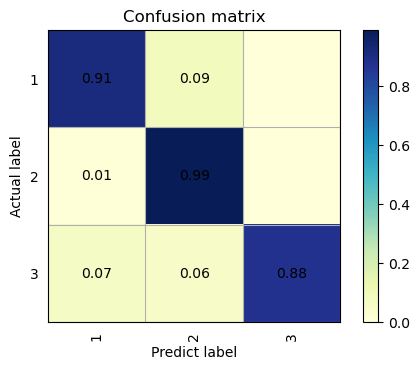

In [ ]:
best_model = np.array(res.iloc[:1,:1])[0].tolist()
y_pred = predictor.predict(X_train,model=best_model)
y_true = y_train

classes = [1,2,3]
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, title='Confusion matrix')

# Test set performance  

## test 1

In [ ]:
test_set1 = pd.read_csv(save_path + "./input/test_set1.csv")
test_set1 = test_set1.drop(columns=["stay_id"])
print(d2_, "samples:",test_set1.shape[0])
y_test = test_set1[label]
X_test = test_set1.drop(columns=[label]) 
print(y_test.value_counts())

predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
print("best model:", predictor.get_model_best())

### model performance

In [ ]:

print("test set:",d2_,"samples",test_set1.shape[0])
res = predictor.leaderboard(test_set1, silent=True,extra_metrics=['accuracy','balanced_accuracy',"precision_macro","precision_micro","precision_weighted","recall_macro","recall_micro","recall_weighted", 
'f1_weighted',"f1_macro","f1_micro"])
res = res.iloc[:,:14]

model_lst = res.model.unique().tolist()
y_true = y_test
res_eachlabel = pd.DataFrame()
for one_model in model_lst:
    y_pred = predictor.predict(X_test,model=one_model)
    t = classification_report(y_true, y_pred, target_names=["1","2","3"],output_dict=True)
    df_t = pd.DataFrame.from_dict(t)
    df_t = df_t.drop(["macro avg","weighted avg", 'accuracy'],axis=1)
    df_t.columns = ['C1', 'C2', 'C3'] #, 'macro', 'weighted'
    new_columns = [row + '_' + col for row in df_t.index for col in df_t.columns ]
    df_t = pd.DataFrame(df_t.values.flatten()).T
    df_t.columns = new_columns
    res_eachlabel = pd.concat([res_eachlabel, df_t],axis=0)
res_eachlabel['model'] = model_lst
res_eachlabel = res_eachlabel.filter(regex=r'^(?!support)')

# merge out
res_ = pd.merge(res,res_eachlabel,how="inner",on="model")
res_ = res_.rename(columns={"score_val":"OVO_macro_AUC_val","score_test":"OVO_macro_AUC_test","f1-score_C1":"f1_C1","f1-score_C2":"f1_C2","f1-score_C3":"f1_C3"})
res_ =res_[['model', 'OVO_macro_AUC_test','OVO_macro_AUC_val', 'accuracy',  'precision_macro',
       'recall_macro', 'f1_macro','precision_C1', 'precision_C2', 'precision_C3', 'recall_C1',
       'recall_C2', 'recall_C3', 'f1_C1', 'f1_C2', 'f1_C3']]
OVO_macro_AUC_dict = dict(zip(res_["model"].tolist(), res_["OVO_macro_AUC_test"].tolist()))
res_ = res_.round(4)

outname = "result_test_" + str(d2_) +".csv"
print("output:",outname)
res_.to_csv(save_path + "/result/result_test_" + str(d2_) +".csv")
res_

### confusion matrix

['eicu', 'mimic']:
 XGBoost_BAG_L2


<Figure size 432x288 with 0 Axes>

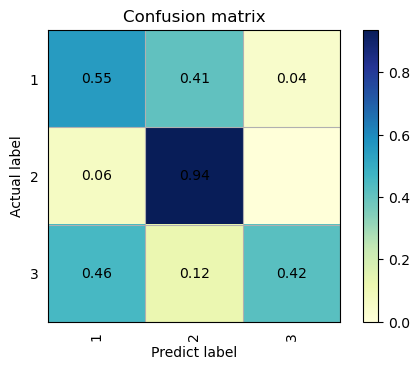

In [ ]:

best_model = [predictor.get_model_best()]  

print(str(d2_)+":\n",str(best_model[0]))
y_true = y_test
y_pred = predictor.predict(X_test,model=best_model)

classes = [1,2,3]
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
plt.figure(figsize=(6,4)) 
plot_confusion_matrix(cm_normalized, title='Confusion matrix')
tit = save_path + "/result/confusion_matrix_test1.pdf"
plt.savefig(tit, format='pdf')
plt.close()
plt.show()

### AUC
- macro_ovo
- OVO 
- OVR

CatBoost_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


ExtraTreesGini_BAG_L1
KNeighborsDist_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


XGBoost_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBM_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBMXT_BAG_L1
NeuralNetTorch_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


RandomForestGini_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


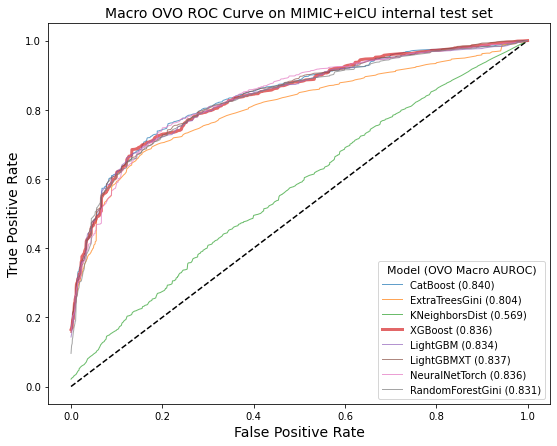

In [ ]:
# macro_ovo
def get_macro_ovo_aucplot(one_model, X, y,lw):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc,roc_auc_score
    from scipy import interp
    import numpy as np
    import matplotlib.pyplot as plt
    n_classes = 3
    y_true = label_binarize(y, classes=[1, 2, 3])
    y_score = np.array(predictor.predict_proba(X, model=one_model,as_pandas=True))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            y_true_ij = y_true[(y == i + 1) | (y == j + 1)]
            y_score_ij = y_score[(y == i + 1) | (y == j + 1)]
            fpr_ij, tpr_ij, _ = roc_curve(y_true_ij[:, i], y_score_ij[:, i])
            roc_auc_ij = round(auc(fpr_ij, tpr_ij),4)
#            print(i,j, roc_auc_ij)
            fpr[(i, j)] = fpr_ij
            tpr[(i, j)] = tpr_ij
            roc_auc[(i, j)] = roc_auc_ij
            fpr_ji, tpr_ji, _ = roc_curve(y_true_ij[:, j], y_score_ij[:, j])
            roc_auc_ji = round(auc(fpr_ji, tpr_ji),4)
#            print(j,i,roc_auc_ji)
            fpr[(j, i)] = fpr_ji
            tpr[(j, i)] = tpr_ji
            roc_auc[(j, i)] = roc_auc_ji
    all_fpr = np.unique(np.concatenate([fpr[ij] for ij in roc_auc.keys()]))
    mean_tpr = np.zeros_like(all_fpr)

    for ij in roc_auc.keys():
        mean_tpr += interp(all_fpr, fpr[ij], tpr[ij])
    mean_tpr /= len(roc_auc)
    fpr["macro_ovo"] = all_fpr
    tpr["macro_ovo"] = mean_tpr
    roc_auc["macro_ovo"] = round(auc(fpr["macro_ovo"], tpr["macro_ovo"]),4)
#    print(roc_auc)
    #plt.plot(all_fpr, mean_tpr, alpha=0.7, linewidth=2, label='%s (AUC = %0.3f)' % (one_model, roc_auc["macro_ovo"]))
    plt.plot(all_fpr, mean_tpr, alpha=0.7, linewidth=lw, label='%s (%0.3f)' % (one_model.split('_')[0], OVO_macro_AUC_dict[one_model]))
    plt.legend(loc='lower right', title = "Model (OVO Macro AUROC)", title_fontsize = 11) # , bbox_to_anchor=(1, 1)
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.title('Macro OVO ROC Curve on MIMIC+eICU internal test set',fontsize=14)
    return fpr, roc_auc

plt.figure(figsize=(9,7))
plt.plot([0,1], [0,1], color='black', linestyle='--')
model_lst = res.model.unique().tolist()

prefix_dict = {}
for item in model_lst:
    prefix = item.split('_')[0]
    if prefix not in prefix_dict:
        prefix_dict[prefix] = []
    prefix_dict[prefix].append(item)
model_lst_filt = [best_model[0]]
for prefix, items in prefix_dict.items():
    selected_item = random.choice(items)
    model_lst_filt.append(selected_item)
    
model_lst_filt = ['CatBoost_BAG_L2','ExtraTreesGini_BAG_L1','KNeighborsDist_BAG_L1','XGBoost_BAG_L2', 
                  'LightGBM_BAG_L2','LightGBMXT_BAG_L1','NeuralNetTorch_BAG_L2','RandomForestGini_BAG_L2']    
# plot
for one_model in model_lst_filt:  
    print(one_model)
    if one_model == best_model[0]:
        fpr, roc_auc = get_macro_ovo_aucplot(one_model, X_test, y_test,3)
    else:
        fpr, roc_auc = get_macro_ovo_aucplot(one_model, X_test, y_test,1)
tit = save_path + "/result/Macro_OVO_ROC_Curve_on_MIMIC_eICU_test_set.pdf"
plt.savefig(tit, format='pdf')

best_model: XGBoost_BAG_L2
DR vs RR ROC AUC OvO: 0.8505
DR vs PW ROC AUC OvO: 0.6168
RR vs DR ROC AUC OvO: 0.8635
RR vs PW ROC AUC OvO: 0.9427
PW vs DR ROC AUC OvO: 0.7998
PW vs RR ROC AUC OvO: 0.9426
macro ROC AUC OvO: 0.8360


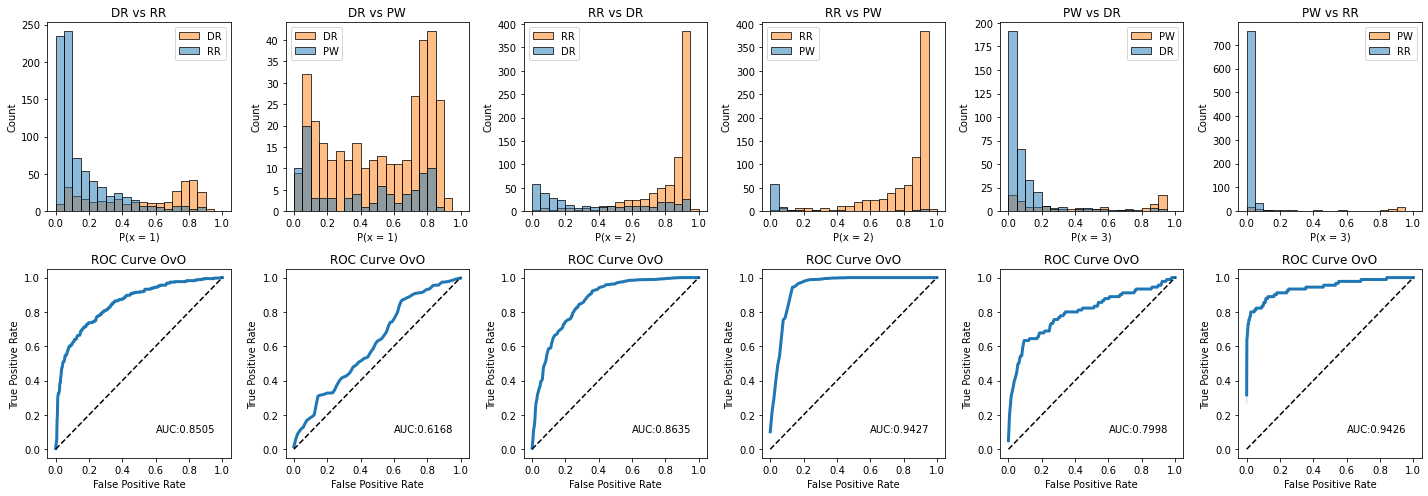

In [16]:
# ovo
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    return tpr, fpr

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, linewidth=3)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax,linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    
import seaborn as sns
from sklearn.metrics import roc_auc_score
one_model = predictor.get_model_best()
print("best_model:",one_model)
y_prob = np.array(predictor.predict_proba(X_test, model=one_model,as_pandas=True))
tpr_list = []
fpr_list = []
### OVO ### 
# Plots the Probability Distributions and the ROC Curves One vs One
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}
class_list = list([1,2,3])
classes_combinations = [[1,2],[1,3],[2,1],[2,3],[3,1],[3,2]]
map_dict = {1:"DR",2:"RR",3:"PW"}
for i in range(len(classes_combinations)):
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = map_dict[c1] + " vs " + map_dict[c2] #"C" + str(c1) + " vs " + "C" + str(c2)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_prob[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    #ax.legend([f"C{c1}", f"C{c2}"])
    ax.legend([map_dict[c1], map_dict[c2]])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    ax_bottom.text(0.6,0.1,"AUC:"+str(round(roc_auc_ovo[title],4)))
plt.tight_layout()

# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"macro ROC AUC OvO: {avg_roc_auc/i:.4f}")
tit = save_path + "/result/all_OVO_ROC_Curve_on_MIMIC_eICU_test_set.pdf"
plt.savefig(tit, format='pdf')

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


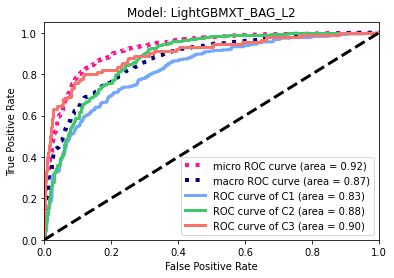

C1 ROC AUC OvR: 0.8268
C2 ROC AUC OvR: 0.8801
C3 ROC AUC OvR: 0.9000
macro AUC OvR: 0.8690


In [66]:
### OVR ### 
from scipy import interp
from itertools import cycle

# y_pred = predictor.predict(X_test, model=one_model)
# y_score = label_binarize(y_pred, classes=[1, 2,3])
y_label = label_binarize(y_test, classes=[1, 2,3])
y_score = np.array(predictor.predict_proba(X_test, model=one_model,as_pandas=True))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i],_ = roc_curve(y_label[:, i],y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"],tpr["micro"],_ = roc_curve(y_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])
# macro-average 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot 
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(["#74a8ff","#3fc968","#f8746a"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label='ROC curve of C{0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model: LightGBMXT_BAG_L2", fontsize=12)
plt.legend(loc="lower right")
plt.show()

# Displays the ROC AUC for each class
roc_auc_ovr = [roc_auc[0],roc_auc[1],roc_auc[2]]
avg_roc_auc = 0
i = 0
for k in range(3):
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"C{k+1} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"macro AUC OvR: {avg_roc_auc/i:.4f}")

## Test 2

In [ ]:
test_set2 = pd.read_csv(save_path + "./input/test_set2.csv")
test_set2 = test_set2.drop(columns=["stay_id"])

print(d3_, "samples:",test_set2.shape[0])
y_test = test_set2[label]
X_test = test_set2.drop(columns=[label]) 

predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
print("best model:", predictor.get_model_best())

### model performance

In [ ]:

print("test set",d3_,"samples:",test_set2.shape[0])
res = predictor.leaderboard(test_set2, silent=True,extra_metrics=['accuracy','balanced_accuracy',"precision_macro","precision_micro","precision_weighted","recall_macro","recall_micro","recall_weighted", 
'f1_weighted',"f1_macro","f1_micro"])
res = res.iloc[:,:14]


model_lst = res.model.unique().tolist()
y_true = y_test
res_eachlabel = pd.DataFrame()
for one_model in model_lst:
    y_pred = predictor.predict(X_test,model=one_model)
    t = classification_report(y_true, y_pred, target_names=["1","2","3"],output_dict=True)
    df_t = pd.DataFrame.from_dict(t)
    df_t = df_t.drop(["macro avg","weighted avg", 'accuracy'],axis=1)
    df_t.columns = ['C1', 'C2', 'C3'] #, 'macro', 'weighted'
    new_columns = [row + '_' + col for row in df_t.index for col in df_t.columns ]
    df_t = pd.DataFrame(df_t.values.flatten()).T
    df_t.columns = new_columns
    res_eachlabel = pd.concat([res_eachlabel, df_t],axis=0)
res_eachlabel['model'] = model_lst
res_eachlabel = res_eachlabel.filter(regex=r'^(?!support)')

# merge out
res_ = pd.merge(res,res_eachlabel,how="inner",on="model")
res_ = res_.rename(columns={"score_val":"OVO_macro_AUC_val","score_test":"OVO_macro_AUC_test","f1-score_C1":"f1_C1","f1-score_C2":"f1_C2","f1-score_C3":"f1_C3"})
res_ = res_[['model', 'OVO_macro_AUC_test','OVO_macro_AUC_val', 'accuracy',  'precision_macro',
       'recall_macro', 'f1_macro','precision_C1', 'precision_C2', 'precision_C3', 'recall_C1',
       'recall_C2', 'recall_C3', 'f1_C1', 'f1_C2', 'f1_C3']]
OVO_macro_AUC_dict = dict(zip(res_["model"].tolist(), res_["OVO_macro_AUC_test"].tolist()))
res_ = res_.round(4)
outname = "result_test_" + str(d3_) +".csv"
print("output:",outname)
res_.to_csv(save_path + "/result/result_test_" + str(d3_) +".csv")
res_

### confusion matrix

aumcdb:
 XGBoost_BAG_L2


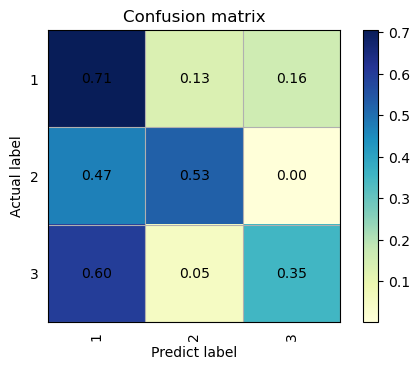

<Figure size 432x288 with 0 Axes>

In [ ]:
best_model = [predictor.get_model_best()]  

print(str(d3_)+":\n",str(best_model[0]))
y_true = y_test
y_pred = predictor.predict(X_test,model=best_model)

classes = [1,2,3]
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot
plot_confusion_matrix(cm_normalized, title='Confusion matrix')
tit = save_path + "/result/confusion_matrix_test2.png"
plt.savefig(tit, format='png')
plt.show()

### AUC

CatBoost_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


ExtraTreesGini_BAG_L1
KNeighborsDist_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


XGBoost_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBM_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBMXT_BAG_L1
NeuralNetTorch_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


RandomForestGini_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


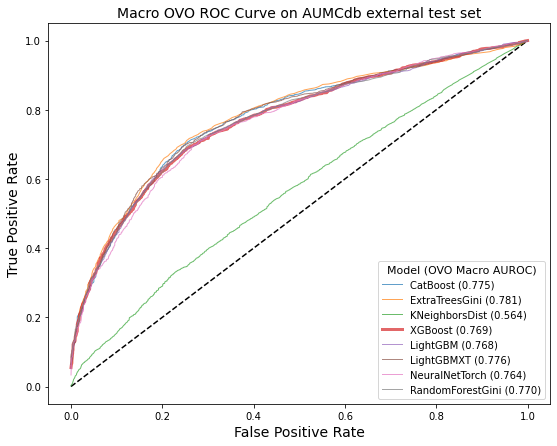

In [ ]:
def get_macro_ovo_aucplot(one_model, X, y,lw):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc,roc_auc_score
    from scipy import interp
    import numpy as np
    import matplotlib.pyplot as plt
    n_classes = 3
    y_true = label_binarize(y, classes=[1, 2, 3])
    y_score = np.array(predictor.predict_proba(X, model=one_model,as_pandas=True))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            y_true_ij = y_true[(y == i + 1) | (y == j + 1)]
            y_score_ij = y_score[(y == i + 1) | (y == j + 1)]
            fpr_ij, tpr_ij, _ = roc_curve(y_true_ij[:, i], y_score_ij[:, i])
            roc_auc_ij = round(auc(fpr_ij, tpr_ij),4)
#            print(i,j, roc_auc_ij)
            fpr[(i, j)] = fpr_ij
            tpr[(i, j)] = tpr_ij
            roc_auc[(i, j)] = roc_auc_ij
            fpr_ji, tpr_ji, _ = roc_curve(y_true_ij[:, j], y_score_ij[:, j])
            roc_auc_ji = round(auc(fpr_ji, tpr_ji),4)
#            print(j,i,roc_auc_ji)
            fpr[(j, i)] = fpr_ji
            tpr[(j, i)] = tpr_ji
            roc_auc[(j, i)] = roc_auc_ji
    all_fpr = np.unique(np.concatenate([fpr[ij] for ij in roc_auc.keys()]))
    mean_tpr = np.zeros_like(all_fpr)

    for ij in roc_auc.keys():
        mean_tpr += interp(all_fpr, fpr[ij], tpr[ij])
    mean_tpr /= len(roc_auc)
    fpr["macro_ovo"] = all_fpr
    tpr["macro_ovo"] = mean_tpr
    roc_auc["macro_ovo"] = round(auc(fpr["macro_ovo"], tpr["macro_ovo"]),4)
#    print(roc_auc)
    #plt.plot(all_fpr, mean_tpr, alpha=0.7, linewidth=2, label='%s (AUC = %0.3f)' % (one_model, roc_auc["macro_ovo"]))
    plt.plot(all_fpr, mean_tpr, alpha=0.7, linewidth=lw, label='%s (%0.3f)' % (one_model.split('_')[0], OVO_macro_AUC_dict[one_model]))    
    plt.legend(loc='lower right', title = "Model (OVO Macro AUROC)", title_fontsize = 11) # , bbox_to_anchor=(1, 1)
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.title('Macro OVO ROC Curve on AUMCdb external test set',fontsize=14)
    return fpr, roc_auc


plt.figure(figsize=(9,7))
plt.plot([0,1], [0,1], color='black', linestyle='--')
model_lst = res.model.unique().tolist()
# prefix_dict = {}
# for item in model_lst:
#     prefix = item.split('_')[0]
#     if prefix not in prefix_dict:
#         prefix_dict[prefix] = []
#     prefix_dict[prefix].append(item)
# model_lst_filt = [best_model[0]]
# for prefix, items in prefix_dict.items():
#     selected_item = random.choice(items)
#     model_lst_filt.append(selected_item)

model_lst_filt = ['CatBoost_BAG_L2','ExtraTreesGini_BAG_L1','KNeighborsDist_BAG_L1','XGBoost_BAG_L2','LightGBM_BAG_L2','LightGBMXT_BAG_L1','NeuralNetTorch_BAG_L2',
                  'RandomForestGini_BAG_L2']    
# plot
for one_model in model_lst_filt:  
    print(one_model)
    if one_model == best_model[0]:
        fpr, roc_auc = get_macro_ovo_aucplot(one_model, X_test, y_test,3)
    else:
        fpr, roc_auc = get_macro_ovo_aucplot(one_model, X_test, y_test,1)
tit = save_path + "/result/Macro_OVO_ROC_Curve_on_AUMCdb_test_set.pdf"
plt.savefig(tit, format='pdf')

best_model: XGBoost_BAG_L2
DR vs RR ROC AUC OvO: 0.6680
DR vs PW ROC AUC OvO: 0.5931
RR vs DR ROC AUC OvO: 0.8371
RR vs PW ROC AUC OvO: 0.9245
PW vs DR ROC AUC OvO: 0.6730
PW vs RR ROC AUC OvO: 0.9187
macro ROC AUC OvO: 0.7691


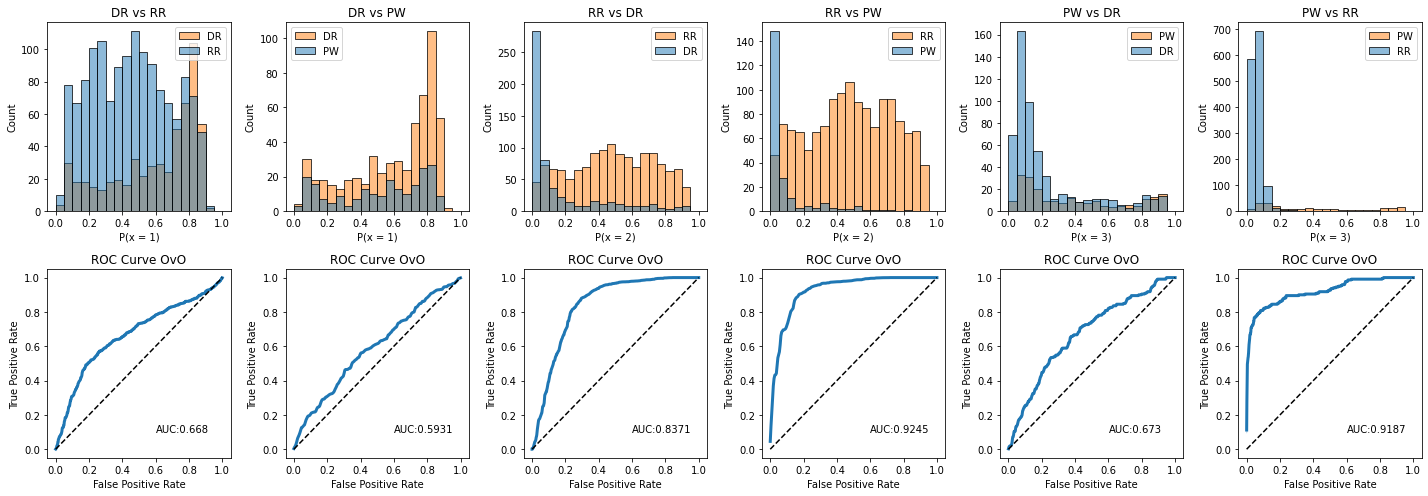

In [18]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    return tpr, fpr

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, linewidth=3)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax,linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    
import seaborn as sns
from sklearn.metrics import roc_auc_score
one_model = predictor.get_model_best()
print("best_model:",one_model)
y_prob = np.array(predictor.predict_proba(X_test, model=one_model,as_pandas=True))
tpr_list = []
fpr_list = []
### OVO ### 
# Plots the Probability Distributions and the ROC Curves One vs One
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}
class_list = list([1,2,3])
classes_combinations = [[1,2],[1,3],[2,1],[2,3],[3,1],[3,2]]
map_dict = {1:"DR",2:"RR",3:"PW"}
for i in range(len(classes_combinations)):
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
#    title = "C" + str(c1) + " vs " + "C" + str(c2)
    title = map_dict[c1] + " vs " + map_dict[c2]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_prob[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
#    ax.legend([f"C{c1}", f"C{c2}"])
    ax.legend([map_dict[c1], map_dict[c2]])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    ax_bottom.text(0.6,0.1,"AUC:"+str(round(roc_auc_ovo[title],4)))
plt.tight_layout()

# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"macro ROC AUC OvO: {avg_roc_auc/i:.4f}")
tit = save_path + "/result/all_OVO_ROC_Curve_on_AUMCdb_test_set.pdf"
plt.savefig(tit, format='pdf')

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


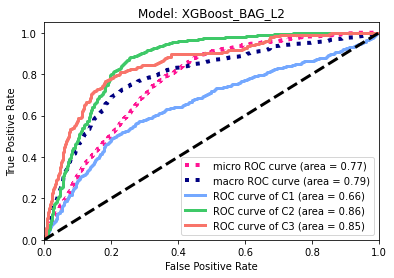

C1 ROC AUC OvR: 0.6579
C2 ROC AUC OvR: 0.8615
C3 ROC AUC OvR: 0.8482
macro AUC OvR: 0.7892


In [72]:
### OVR ### 
from scipy import interp
from itertools import cycle

# y_pred = predictor.predict(X_test, model=one_model)
# y_score = label_binarize(y_pred, classes=[1, 2,3])
y_label = label_binarize(y_test, classes=[1, 2,3])
y_score = np.array(predictor.predict_proba(X_test, model=one_model,as_pandas=True))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i],_ = roc_curve(y_label[:, i],y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"],tpr["micro"],_ = roc_curve(y_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])
# macro-average 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot 
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(["#74a8ff","#3fc968","#f8746a"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label='ROC curve of C{0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model: "+one_model, fontsize=12)
plt.legend(loc="lower right")
plt.show()

# Displays the ROC AUC for each class
roc_auc_ovr = [roc_auc[0],roc_auc[1],roc_auc[2]]
avg_roc_auc = 0
i = 0
for k in range(3):
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"C{k+1} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"macro AUC OvR: {avg_roc_auc/i:.4f}")

# Feature importance
https://github.com/autogluon/autogluon/blob/master/examples/tabular/interpret/SHAP%20with%20AutoGluon-Tabular.ipynb

In [ ]:
test_set1 = pd.read_csv(save_path + "./input/test_set1.csv")
test_set1 = test_set1.drop(columns=["stay_id"])
print(d2_, "samples:",test_set1.shape[0])

label_counts = test_set1[label].value_counts()
print(label_counts)
sampled_df = pd.DataFrame()
for label_value, count in label_counts.items():
    sampled_df = sampled_df.append(test_set1[test_set1[label] == label_value].sample(n= 50,replace=True)) # n= label_counts[3], replace=False
test_set1 = sampled_df
print(d2_, "Sample size after sampling:",test_set1.shape[0])

y_test = test_set1[label]
X_test = test_set1.drop(columns=[label]) 

In [ ]:
predictor_multi = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
#model_fi = predictor_multi.feature_importance(train_set) # ,model=

In [ ]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names, target_class=None):
        self.ag_model = predictor
        self.feature_names = feature_names
        self.target_class = target_class
        if target_class is None and predictor.problem_type != 'regression':
            print("Since target_class not specified, SHAP will explain predictions for each class")
    
    def predict_proba(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        preds = self.ag_model.predict_proba(X)
        if predictor.problem_type == "regression" or self.target_class is None:
            return preds
        else:
            return preds[self.target_class] 

In [ ]:
baseline = X_train.sample(1000, random_state=30)

ag_wrapper = AutogluonWrapper(predictor_multi, X_train.columns)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)
print("Baseline prediction: \n", ag_wrapper.predict_proba(baseline).mean())  # this is the same as explainer.expected_value

NSHAP_SAMPLES = 400  # how many samples to use to approximate each Shapely value, larger values will be slower

In [ ]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES,model=best_model ) #best_model
filename = save_path + r'/result/shap_related.pkl'
save_lst = ["shap_values"]
my_save(save_lst, filename, globals())

## Beeswarm diagram
Each point is a sample (person), and the picture contains all the samples
X-axis: Samples are sorted by Shap value -
Y-axis: Features are sorted by Shap value
Color: The larger the value of the feature, the redder it is

In [ ]:
filename = save_path + r'/result/shap_related.pkl'
my_load(filename, globals())

In [ ]:
X_test.rename(columns=lambda x: x.replace('crea_divide_basecrea', 'Scr/bScr'), inplace=True) 

In [ ]:
shap.summary_plot(shap_values[0], X_test, show=False, max_display=10) #,save=True,path=pth,show=False
tit = save_path + "/result/shap_beeswarm_test_C1.pdf"
plt.savefig(tit, format='pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
shap.summary_plot(shap_values[1], X_test, show=False, max_display=10)
tit = save_path + "/result/shap_beeswarm_test_C2.pdf"
plt.savefig(tit, format='pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
shap.summary_plot(shap_values[2], X_test, show=False, max_display=10)
tit = save_path + "/result/shap_beeswarm_test_C3.pdf"
plt.savefig(tit, format='pdf', bbox_inches = 'tight')
plt.show()

## Force_plot

In [ ]:
class_of_interest = 3  # can be any value in set(y_train)
class_index = predictor_multi.class_labels.index(class_of_interest)
print(f"Force_plot for class: {class_of_interest}")
shap.force_plot(explainer.expected_value[class_index], shap_values[class_index], X_test)


## bar 1

In [ ]:
# shap.summary_plot(shap_values, X_test, show = False, max_display=10, plot_type="bar")#, feature_names = np.array(["C1","C2","C3"])) #
# plt.tight_layout()
# plt.show()
# print({"Class "+str(i) : predictor_multi.class_labels[i] for i in range(len(predictor_multi.class_labels))})

num_unit = 10
shap.summary_plot(shap_values, X_test, show = False, max_display=num_unit, plot_type="bar") 
colors = ["#91cf60","#91bfdb","#fc8d59"]
bars = plt.gca().patches

for i, bar in enumerate(bars):
    j = 0 
    if i >= num_unit:
        j = 1
    if i >= num_unit*2:
        j = 2
    bar.set_color(colors[j]) #colors[i % len(colors)]
    
labels = ['C2', 'C1', 'C3']  
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(handles, labels)
tit = save_path + "/result/shap_bar_test.pdf"
plt.savefig(tit, format='pdf', bbox_inches = 'tight')
plt.show()

## bar 2

In [ ]:
fig = plt.figure(figsize=(30,5))

ax0 = fig.add_subplot(131)
ax0.title.set_text('C1')
shap.summary_plot(shap_values[0], X_test, plot_type="bar", show=False, max_display=10)
bars = plt.gca().patches
for i, bar in enumerate(bars):
    bar.set_color(colors[1])
ax0.set_xlabel(r'SHAP values', fontsize=12)
plt.subplots_adjust(wspace = 2)

ax1 = fig.add_subplot(132)
ax1.title.set_text('C2')
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False, max_display=10)
plt.subplots_adjust(left=0.001, right=0.99, bottom=0.1, top=0.9)
bars = plt.gca().patches
for i, bar in enumerate(bars):
    bar.set_color(colors[0])
ax1.set_xlabel(r'SHAP values', fontsize=12)

ax2 = fig.add_subplot(133)
ax2.title.set_text('C3')
shap.summary_plot(shap_values[2], X_test, plot_type="bar", show=False, max_display=10)
plt.subplots_adjust(left=0.00001, right=0.99, bottom=0.1, top=0.9)
bars = plt.gca().patches
for i, bar in enumerate(bars):
    bar.set_color(colors[2])
ax2.set_xlabel(r'SHAP values', fontsize=12)
plt.tight_layout(pad=2)  
tit = save_path + "/result/shap_bar2_test.pdf"
plt.savefig(tit, format='pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# ROW_INDEX = 0  # index of an example datapoint
# class_of_interest = 1  # can be any value in set(y_train)
# class_index = predictor_multi.class_labels.index(class_of_interest)

# single_datapoint = X_train.iloc[[ROW_INDEX]]
# single_prediction = ag_wrapper.predict_proba(single_datapoint)

# shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
# print("Shapely values: \n", {predictor_multi.class_labels[i]:shap_values_single[i] for i in range(len(predictor_multi.class_labels))})

# print(f"Force_plot for class: {class_of_interest}")
# shap.force_plot(explainer.expected_value[class_index], shap_values_single[class_index], X_train.iloc[ROW_INDEX,:])

# some knowledge

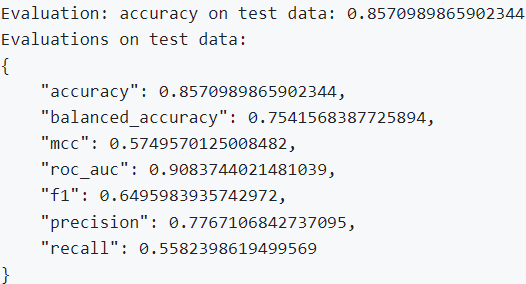

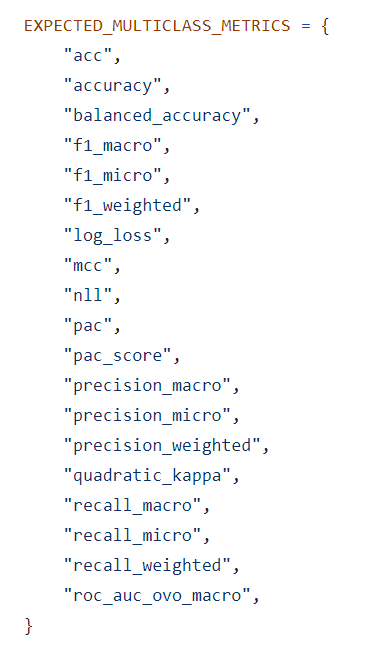

In [ ]:
'accuracy','balanced_accuracy',"precision_macro","precision_micro","precision_weighted","recall_macro","recall_micro","recall_weighted", 
'f1_weighted',"f1_macro","f1_micro","roc_auc_ovo_macro"

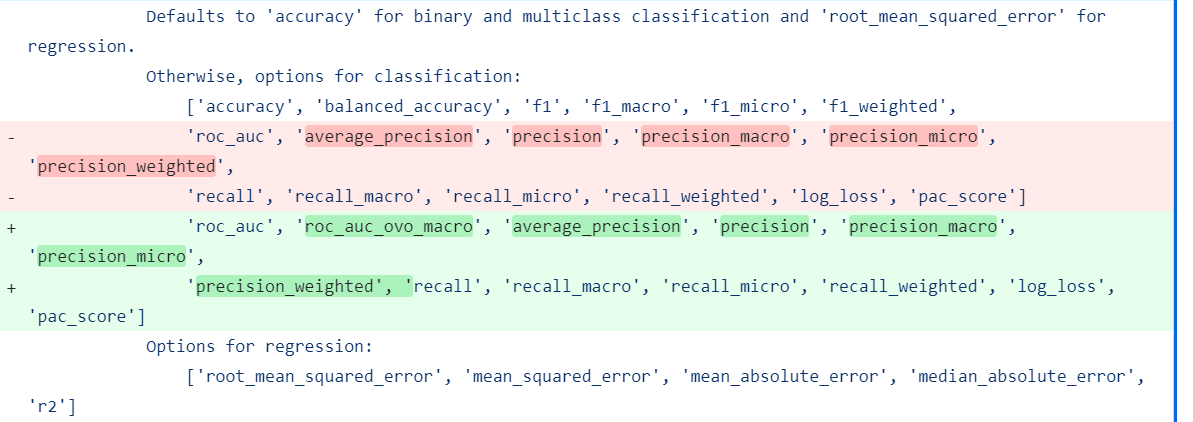

In [ ]:
# accurcy recall roc f1  
# accurcy recall roc f1  macro micro weighted 

In [ ]:
# https://docs.aws.amazon.com/zh_cn/sagemaker/latest/dg/autogluon-tabular-HowItWorks.html

In [ ]:
# def get_aucplot(one_model,X,y):
#     from sklearn.preprocessing import label_binarize
#     from sklearn.metrics import roc_curve, auc
#     from scipy import interp
#     n_classes = 3
# #     y_pred = predictor.predict(X, model=one_model)
# #     y_score = label_binarize(y_pred, classes=[1, 2,3])
#     y_score = np.array(predictor.predict_proba(X, model=one_model,as_pandas=True))
#     y_true = label_binarize(y, classes=[1, 2,3])
    
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     for i in range(n_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])
#     all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
#     mean_tpr = np.zeros_like(all_fpr)
#     for i in range(n_classes):
#         mean_tpr += interp(all_fpr, fpr[i], tpr[i])
#     mean_tpr /= n_classes
#     fpr["macro"] = all_fpr
#     tpr["macro"] = mean_tpr
#     roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
#     plt.plot(all_fpr, mean_tpr,alpha=0.7, linewidth=3, label='%s (AUC = %0.4f)' % (one_model, roc_auc["macro"])) # Macro
#     plt.legend(loc='lower right')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     return fpr, roc_auc
# plt.figure(figsize=(10,7))
# model_lst = res.model.unique().tolist()
# for one_model in model_lst[0:3]: # 
#     print(one_model)
#     fpr, roc_auc = get_aucplot(one_model,X_test,y_test)

In [ ]:
# plt.figure(figsize=(10,7))
# model_lst = res.model.unique().tolist()
# for one_model in model_lst: # [0:3]
#     print(one_model)
#     fpr, roc_auc = get_aucplot(one_model,X_test,y_test)

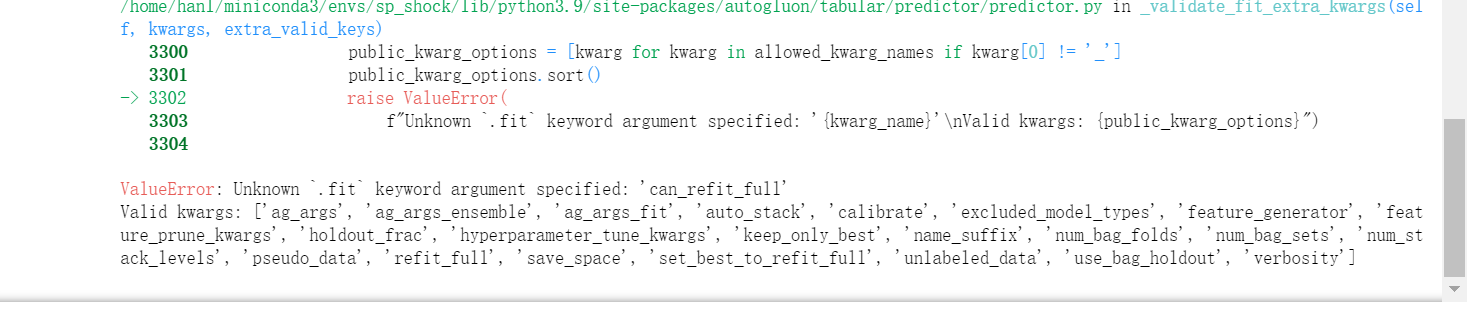